# Problem 1 

In [1]:
from scipy.special import expit
import os
import gzip
import pickle
import wget
import random
import numpy as np
from scipy.special import softmax
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline

import math

In [2]:
def plotThis(x, label ):
    xnew = np.linspace(np.arange(x.shape[0]).min(),np.arange(x.shape[0]).max(),300)
    spl = make_interp_spline(np.arange(x.shape[0]),x, k=3)
    power_smooth = spl(xnew)
    xx = plt.plot(xnew,power_smooth, label = label)

def vectorized_result(y):
    e = np.zeros((10, 1))
    e[y] = 1.0
    return e

def load_mnist():
    if not os.path.exists(os.path.join(os.curdir, 'data')):
        os.mkdir(os.path.join(os.curdir, 'data'))
        wget.download('http://deeplearning.net/data/mnist/mnist.pkl.gz', out='data')

    data_file = gzip.open(os.path.join(os.curdir, 'data', 'mnist.pkl.gz'), 'rb')
    training_data, validation_data, test_data = pickle.load(data_file, encoding='latin1')
    data_file.close()

    training_inputs = np.squeeze(np.asarray([np.reshape(x, (784, 1)) for x in training_data[0]]))
    training_results = np.squeeze(np.asarray([vectorized_result(y) for y in training_data[1]]))

    validation_inputs = np.squeeze(np.asarray([np.reshape(x, (784, 1)) for x in validation_data[0]]))
    validation_results = np.asarray(validation_data[1])
    
    test_inputs = np.squeeze(np.asarray([np.reshape(x, (784, 1)) for x in test_data[0]]))
    test_results = np.squeeze(np.asarray(test_data[1]))
    return training_inputs, training_results, validation_inputs, validation_results, test_inputs, test_results

training_inputs, training_results, validation_inputs, validation_results, test_inputs, test_results= load_mnist()

In [3]:
np.random.seed(5)
def softmaxx(z):
        return softmax(z, axis=1)

def sigmoid(z):
    return expit(z)

def sigmoid_prime(z):
    return z*(1-z)

def ReLU(z):
    return np.maximum(z, 0)

def ReLU_prime(x):
    return np.where(x > 0, 1.0, 0.0)

def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1.0 - x**2

    
class NN(object):
    def __init__(self, network_units, activation_fn, lr, batch_size, initialization):
        self.network_units = network_units
        if activation_fn =="ReLU":
            self.activation_fn = ReLU
            self.activation_p = ReLU_prime
        elif activation_fn == "sigmoid":
            self.activation_fn = sigmoid
            self.activation_p = sigmoid_prime
        elif activation_fn == "tanh":
            self.activation_fn = tanh
            self.activation_p = tanh_prime
        self.parameters = {}
        self.gradients = {}
        self.initialization = initialization
        self.initialize_weights()
        self.lr = lr
        self.batch_size = batch_size
    def initialize_weights(self):
        
        for i in range(len(self.network_units)-1):
            
            self.parameters["b"+str(i)] = np.zeros((self.network_units[i+1]))
            
            if self.initialization == "glorot":
                self.parameters["w"+str(i)] = np.random.uniform( 
                                -np.sqrt(6./(self.network_units[i]+self.network_units[i+1])), 
                                np.sqrt(6./(self.network_units[i]+self.network_units[i+1])),
                                size=(self.network_units[i],self.network_units[i+1])
                                                              )
            elif self.initialization == "normal":
                self.parameters["w"+str(i)] = np.random.normal(scale=1, size=(self.network_units[i],self.network_units[i+1]))
            
            elif self.initialization == "zero":
                self.parameters["w"+str(i)] = np.zeros(shape=(self.network_units[i],self.network_units[i+1]))
    
            self.gradients["b"+str(i)] = np.zeros((self.network_units[i+1]))
            self.gradients["w"+str(i)] = np.zeros((self.network_units[i], self.network_units[i+1]))

            
    def num_parameters(self):
        pars = 0.0
        for i in range(len(self.network_units)-1):
            pars += self.network_units[i]
            pars += (self.network_units[i] * self.network_units[i+1])
        print("we have ", pars/1000000, " parameters")
    
    def forward(self, x):
        self.x = x
        self.h1 = self.activation_fn(np.dot(x, self.parameters["w0"]) + self.parameters["b0"])
        self.h2 = self.activation_fn(np.dot(self.h1, self.parameters["w1"]) + self.parameters["b1"])
        self.out = expit(np.dot(self.h2, self.parameters["w2"]) + self.parameters["b2"])
        return self.out
    
    def loss(self, y):
        self.y = y
        l = -y*np.log(self.out+1e-8)-(1-y)*np.log(1-self.out+1e-8)
        m_b_l = np.sum(l, axis=1)
        self.lossy = np.mean(m_b_l)
        return self.lossy
    
    def backward(self):
        
        
        dout = (-self.y/(self.out+1e-8)) + (1-self.y) * (1/(1-self.out+1e-8))
        del2 = self.out*(1-self.out)*dout
        doutdw2 = np.dot(self.h2.T, del2)/len(self.x)
        doutdb2 = np.mean(del2, axis=0)
        
        
        douth2 = np.dot(del2, self.parameters["w2"].T)
        del1 = self.activation_p(self.h2)*douth2
        doutdw1 = np.dot(self.h1.T, del1)/len(self.x)
        doutdb1 = np.mean(del1, axis=0)
        
        douth1 = np.dot(del1, self.parameters["w1"].T)
        del0 = self.activation_p(self.h1)*douth1
        doutdw0 = np.dot(self.x.T, del0)/len(self.x)
        doutdb0 = np.mean(del0, axis=0)
        
        self.gradients["w2"] = doutdw2
        self.gradients["b2"] = doutdb2
        self.gradients["w1"] = doutdw1
        self.gradients["b1"] = doutdb1
        self.gradients["w0"] = doutdw0
        self.gradients["b0"] = doutdb0
        
    def grad_check(self, single_training_example, single_training_result, p, row):
        output = self.forward(single_training_example)
        loss = self.loss(single_training_result)
        self.backward()
        all_Ns = []
        max_differences = []
        for k in range(1,5):
            for i in range(0,5):
                N = k * math.pow(10,i)
                all_Ns.append(N)
                
                epsilon = 1.0 / N

                #finite_difference:
                numerical_gradient = 0.0
                max_difference = 0
                for j in range(10):

                    analytic_gradient = self.gradients[p][row][j]
                    #left
                    self.parameters[p][row][j] += epsilon
                    self.forward(single_training_example)
                    left_loss = self.loss(single_training_result)
                    #right
                    self.parameters[p][row][j] -= (2 * epsilon)
                    self.forward(single_training_example)
                    right_loss = self.loss(single_training_result)
                    self.parameters[p][row][j] += epsilon
                    print("\n analytic gradient: ", analytic_gradient)
                    numerical_gradient = (left_loss - right_loss)/ (2*epsilon)
                    print("\n numerical gradient: ", numerical_gradient)
                    current_difference = np.abs(numerical_gradient - analytic_gradient)
                    print("difference: ",current_difference)
                    if current_difference > max_difference:
                        max_difference = current_difference
                max_differences.append(max_difference)
        return all_Ns, max_differences
        
                

    def update(self):
        for ind in ["w0", "w1", "w2", "b0", "b1", "b2"]:
            self.parameters[ind] -= self.lr * self.gradients[ind]
            

    def train(self,training_inputs, training_results, epochs, validation_inputs, validation_targets):
        loss = np.zeros((epochs))
        accuracy = np.zeros((epochs))
        for epoch in range(epochs):
            shuffle(training_inputs, training_results, random_state=0)
            mini_batches = [training_inputs[k:k+self.batch_size] for k in range(0, training_inputs.shape[0], self.batch_size)]
            mini_batches_results = [training_results[k:k+self.batch_size] for k in range(0, training_results.shape[0], self.batch_size)]
            #print(mini_batches_results[0])
            #break
            current_loss=0
            for mini_batch_index in range(len(mini_batches)):
                self.forward(mini_batches[mini_batch_index])
                current_loss += self.loss(mini_batches_results[mini_batch_index])
                self.backward()
                self.update()
            current_loss /= len(mini_batches)
            loss[epoch] = current_loss
            print("loss ", current_loss)
            currentAccuray = self.test(validation_inputs, validation_targets)
            accuracy[epoch] = currentAccuray
        return loss, accuracy 
    def test(self, validation_inputs, validation_targets):
        results = self.forward(validation_inputs)
        labels = np.argmax(results, axis=1)
        accuracy = np.sum(labels == validation_targets)/100
        print("validation accuracy", accuracy)
        return accuracy

## Part 1 --> Initilization:
For I ran the model with 32 as the mini batch size, 500 units for both hidden layers which makes the total number of parameters to be 0.648784 million. I used Tanh activation for the hidden layer non linearities. Learning rate was chosen to be 0.01.



In [4]:
myNet = NN([784,500, 500,10], "tanh", lr=0.01, batch_size=32, initialization="glorot")
glorot_tanh_loss, glorot_tanh_accuracy = myNet.train(training_inputs, training_results, 10, validation_inputs, validation_results)

loss  1.1164179979846724
validation accuracy 90.75
loss  0.6950673664685939
validation accuracy 91.95
loss  0.6050231667101834
validation accuracy 92.72
loss  0.5399757484267349
validation accuracy 93.49
loss  0.4851334667886092
validation accuracy 94.21
loss  0.43879148612648244
validation accuracy 94.78
loss  0.4000609361711174
validation accuracy 95.15
loss  0.36755883622510893
validation accuracy 95.48
loss  0.3399095648145816
validation accuracy 95.7
loss  0.31603467490692777
validation accuracy 95.93


In [ ]:
myNet.num_parameters()

In [ ]:
myNet = NN([784,500,500,10], "tanh", lr=0.01, batch_size=32, initialization="normal")
normal_tanh_loss, normal_tanh_accuracy = myNet.train(training_inputs, training_results, 10, validation_inputs, validation_results)

In [ ]:
myNet = NN([784,500,500,10], "tanh", lr=0.01, batch_size=32, initialization="zero")
zero_tanh_loss, zero_tanh_accuracy = myNet.train(training_inputs, training_results, 10, validation_inputs, validation_results)

# Part 1.1:
Above we have shown the loss for every epoch for the three types of initilization. 

# Part 1.2:
The three plots for both losses and accuracies are plotted in the following:
When we have a symmetric(in this case zero initilization) initilization method, we know that the gradients for each of those weights will also be symmetric so all the updates would be same which is in essence equivalent to having only one neuron instead of 500.

When we have gaussian distribution then since we are breaking the symmetry we can learn better than symmetric ones like zero. Also since the standard deviation  is 1 which is large, it quickly saturates the gradients which will slow the learning. 

Using glorot gave the best accuracy and the main reason is possibly because we have neither the problem of gradient saturation nor symmetry. 

In [ ]:
%matplotlib notebook
plotThis(glorot_tanh_loss, "glorot tanh loss")
plotThis(zero_tanh_loss, "zero tanh loss")
plotThis(normal_tanh_loss, "normal tanh loss")

plt.title("training loss")
plt.legend()
plt.show()


In [ ]:
%matplotlib notebook
plotThis(glorot_tanh_accuracy, "glorot tanh accuracy")
plotThis(zero_tanh_accuracy, "zero tanh accuracy")
plotThis(normal_tanh_accuracy, "normal tanh accuracy")

plt.title("evaluation accuracy")
plt.legend()
plt.show()


## Part 2 
For the hyperparameter search, we test with the 450, 500, 550, 600, 650 as the architecture model. For the case of NonLinearity we will test with ReLU, sigmoid and tanh and for the learning rate we will try 0.001, 0.01, 0.1. I will test mini batch size for 32, 64, and 128.

In [ ]:
architecture = [450, 500, 550, 600, 650]
non_linearity = ["ReLU", "sigmoid", "tanh"]
learning_rate = [0.001, 0.01, 0.1]
mini_batch_size = [32, 64, 128]
best_accuracy = 0
best_arch = None 
best_non_linearity = None
best_learning_rate = None
best_mini_batch_size = None
for i in range(len(architecture)):
    for j in range(len(non_linearity)):
        for k in range(len(learning_rate)):
            for l in range(len(mini_batch_size)):
                myNet = NN([784,architecture[i], architecture[i], 10], non_linearity[j], lr=learning_rate[k], batch_size=mini_batch_size[l], initialization="glorot")
                -, accuracy = myNet.train(training_inputs, training_results, 10, validation_inputs, validation_results)
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_arch = i 
                    best_non_linearity = j
                    best_learning_rate = k
                    best_mini_batch_size = l
print("we achieved best accuracy of ", best_accuracy, "with the following hyperparameters:\n ",
                          architecture[best_arch], " --> units for both hidden layers\n",
                          non_linearity[best_non_linearity], "--> the non Linearity chosen for the hidden layer activations\n",
                          learning_rate[best_learning_rate], "--> the learning rate\n", 
                          mini_batch_size[best_mini_batch_size], "--> the size of each mini batch\n"
                        
                          
                         )


## Part 3

In the following we perform gradient checking for different 

In [ ]:
myNet.grad_check(np.asarray([training_inputs[0]]), training_results[0], "w0", 0)


As you can see above all the gradients are zero for the first ten elements(the very first 10 elements of the 1st row) so the difference does not have a real meaning. It will be zero because corner of the image is all black which means all zero in the corner so the weights are going to end up az zero too. However, in the following you can see the gradient not being zero for the 161st row because the input corresponding to this weight is not zero. 


In [ ]:
myNet.grad_check(np.asarray([training_inputs[0]]), training_results[0], "w0", 161)


In [5]:
N, max_differences = myNet.grad_check(np.asarray([training_inputs[0]]), training_results[0], "w1", 0)



 analytic gradient:  -0.0018475346421565233

 numerical gradient:  -0.001853117398069204
difference:  5.58275591268061e-06

 analytic gradient:  -0.0030878904528861078

 numerical gradient:  -0.003067361304479599
difference:  2.0529148406508903e-05

 analytic gradient:  -0.011249423959344397

 numerical gradient:  -0.011154112934348981
difference:  9.531102499541616e-05

 analytic gradient:  -0.002707310654277872

 numerical gradient:  -0.002735754633037546
difference:  2.844397875967396e-05

 analytic gradient:  0.00041258559590594794

 numerical gradient:  0.00041933110705033583
difference:  6.7455111443878875e-06

 analytic gradient:  0.004178465445798795

 numerical gradient:  0.004190538819989209
difference:  1.2073374190414363e-05

 analytic gradient:  0.0037086257917106516

 numerical gradient:  0.00368982586330574
difference:  1.879992840491144e-05

 analytic gradient:  0.0007273623277458714

 numerical gradient:  0.0007241585773087866
difference:  3.2037504370847772e-06

 ana


 analytic gradient:  0.004178465445798795

 numerical gradient:  0.004178465446980084
difference:  1.1812894412654984e-12

 analytic gradient:  0.0037086257917106516

 numerical gradient:  0.003708625793130693
difference:  1.4200416016685313e-12

 analytic gradient:  0.0007273623277458714

 numerical gradient:  0.0007273623253700734
difference:  2.3757980175190263e-12

 analytic gradient:  -0.0037373821237374457

 numerical gradient:  -0.0037373821221153847
difference:  1.6220609924677554e-12

 analytic gradient:  -0.0035300462573121137

 numerical gradient:  -0.0035300462569720636
difference:  3.400500367400916e-13

 analytic gradient:  -0.0018475346421565233

 numerical gradient:  -0.0018478917615731838
difference:  3.5711941666046257e-07

 analytic gradient:  -0.0030878904528861078

 numerical gradient:  -0.0030865996614899416
difference:  1.290791396166193e-06

 analytic gradient:  -0.011249423959344397

 numerical gradient:  -0.011243409905186352
difference:  6.014054158044735e-0

As shown above I tried for the second layer weights and you can properly see that the gradient checking is getting done appropriately. Since the second layers gives me more accurate gradient difference between the numerical and analytic gradient I will plot that only against N:



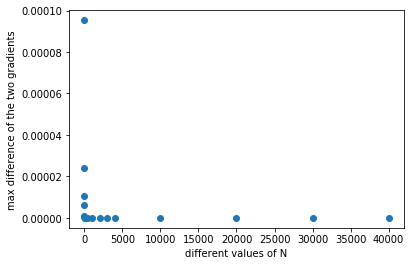

In [9]:

fig, ax = plt.subplots()
ax.plot(N, max_differences, 'o')
plt.ylabel("max difference of the two gradients")
plt.xlabel("different values of N")
plt.show()


The above plot shows that for very low values of N which makes epsilon large it is not good at all. But the larger values of N which make epsilon smaller gives us a more accurate gradient checking. 